In [21]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from statistics import mean
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

%matplotlib notebook

In [22]:
#Read the output csv files of DataCleaning.ipynb which are saved in Google drive 
cpi_df = pd.read_csv("outcome/cpi_data.csv")
wpi_df = pd.read_csv("outcome/wpi_data.csv")


In [23]:
cpi_df.tail()

,Qtr,Sydney,Melbourne,Brisbane,Adelaide,Perth,Hobart,Darwin,Canberra,Australia
52,2022-03-01,1.7,2.3,2.2,1.9,3.3,2.0,2.1,2.2,2.1
53,2022-06-01,1.6,1.8,2.1,2.1,1.7,1.8,2.1,1.6,1.8
54,2022-09-01,2.3,2.1,1.8,2.6,-0.5,2.3,1.9,1.9,1.8
55,2022-12-01,1.8,1.6,1.5,1.7,3.6,1.5,0.9,1.2,1.9
56,2023-03-01,1.4,1.2,1.9,1.2,0.9,1.2,1.3,1.4,1.4


In [24]:
#Drop the last row in the CPI data table just to make the number of CPI data and WPI data records equal.
cpi_df = cpi_df.drop(labels = 56 , axis = 0)

#Drop the columns that contain CPI for differnt cities
cpi_df = cpi_df.drop(cpi_df.iloc[:,1:9], axis = 1)

#Rename the 'Australia' column
cpi_df = cpi_df.rename(columns = {'Australia' : 'CPI_percentage_change'})

cpi_df.tail()

,Qtr,CPI_percentage_change
51,2021-12-01,1.3
52,2022-03-01,2.1
53,2022-06-01,1.8
54,2022-09-01,1.8
55,2022-12-01,1.9


In [25]:
wpi_df.tail()

,Qtr,WPI_percentage_change
51,2021-12-01,0.7
52,2022-03-01,0.7
53,2022-06-01,0.8
54,2022-09-01,1.1
55,2022-12-01,0.8


In [26]:
combined_df = pd.merge(wpi_df,cpi_df,on = "Qtr")
combined_df.head(5)

,Qtr,WPI_percentage_change,CPI_percentage_change
0,2009-03-01,0.9,0.1
1,2009-06-01,0.8,0.4
2,2009-09-01,0.4,1.0
3,2009-12-01,0.8,0.5
4,2010-03-01,1.0,1.0


In [27]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Qtr                    56 non-null     object 
 1   WPI_percentage_change  56 non-null     float64
 2   CPI_percentage_change  56 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.8+ KB


In [28]:
combined_df.set_index("Qtr", inplace = True)


In [29]:
wpi = wpi_df.set_index('Qtr')
wpi.head()

,WPI_percentage_change
Qtr,
2009-03-01,0.9
2009-06-01,0.8
2009-09-01,0.4
2009-12-01,0.8
2010-03-01,1.0


## **Apply Augmented Dickey Fuller Test to find out if WPI Time Series has a stochastic trend**

# The hypotheses for the ADF test:

*   The null hypotheses : Time series is not stationary.
*   The alternative hypotheses : Time series is stationary.


In [30]:
adftest_original = adfuller(wpi_df['WPI_percentage_change'].tolist(), autolag = 'AIC')

adf_test1 = adftest_original[0]
p_val_test1 = adftest_original[1]
lags_test1 = adftest_original[2]
obs_test1 = adftest_original[3]
cv_1_test1 = adftest_original[4]["1%"]
cv_5_test1 = adftest_original[4]["5%"]
cv_10_test1 = adftest_original[4]["10%"]

ADF_test1_summary = pd.DataFrame({"ADF": adf_test1,
                                  "P-Value" : p_val_test1,
                                  "Num of Lags": lags_test1,
                                  "Num of Observations used":obs_test1,
                                  "CV at 1% level": cv_1_test1,
                                  "CV at 5% level": cv_5_test1,
                                  "CV at 10% level": cv_10_test1}, index = [0])

ADF_test1_summary

,ADF,P-Value,Num of Lags,Num of Observations used,CV at 1% level,CV at 5% level,CV at 10% level
0,-2.070267,0.256637,6,49,-3.571472,-2.922629,-2.599336


The p-value of the ADF test is 0.256 which is greater than 0.05 and the ADF test statistic is greater than all 3 critical values. Therefore there is no reason to reject null hypotheses. That means we have to accept that the Time series is not stationary.

### Detrend the Time Series using First Differencing method

In [31]:
#Get the difference of current period vs previous period wpi percentage change
wpi['First_diff_WPI_percentage_change']  = wpi['WPI_percentage_change'] - wpi['WPI_percentage_change'].shift(1)

In [32]:
wpi.head()

,WPI_percentage_change,First_diff_WPI_percentage_change
Qtr,,
2009-03-01,0.9,NaN
2009-06-01,0.8,-0.1
2009-09-01,0.4,-0.4
2009-12-01,0.8,0.4
2010-03-01,1.0,0.2


<IPython.core.display.Javascript object>


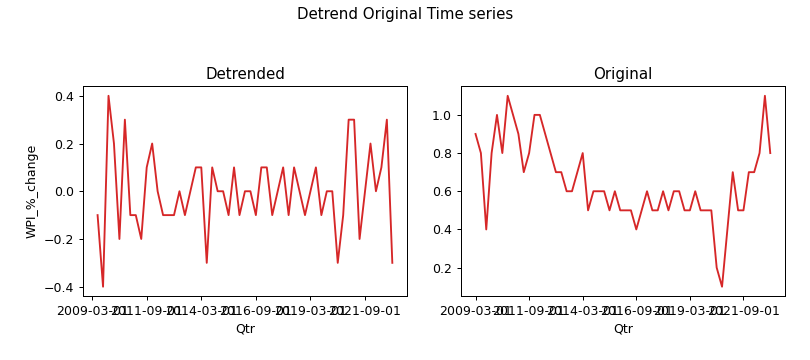

In [33]:
#Create subplots for Original Time series and Regression fit
plt.figure(figsize=(9,4))

ax1 = plt.subplot(1,2,1)
wpi['First_diff_WPI_percentage_change'].plot(color="tab:red", title="Detrended", ax=ax1, ylabel="WPI_%_change")
ax2 = plt.subplot(1,2,2)
wpi['WPI_percentage_change'].plot(color="tab:red", title="Original", ax=ax2)

plt.suptitle("Detrend Original Time series")
plt.tight_layout(pad=2.0)
plt.show()

### Apply ADF test again for the Detrended time series to check for stationary

In [34]:
adftest_detrend = adfuller(wpi['First_diff_WPI_percentage_change'].dropna(), autolag = 'AIC')

adf_test2 = adftest_detrend[0]
p_val_test2 = adftest_detrend[1]
lags_test2 = adftest_detrend[2]
obs_test2 = adftest_detrend[3]
cv_1_test2 = adftest_detrend[4]["1%"]
cv_5_test2 = adftest_detrend[4]["5%"]
cv_10_test2 = adftest_detrend[4]["10%"]

ADF_test2_summary = pd.DataFrame({"ADF": adf_test2,
                                  "P-Value" : p_val_test2,
                                  "Num of Lags": lags_test2,
                                  "Num of Observations used":obs_test2,
                                  "CV at 1% level": cv_1_test2,
                                  "CV at 5% level": cv_5_test2,
                                  "CV at 10% level": cv_10_test2}, index = [0])

ADF_test2_summary

,ADF,P-Value,Num of Lags,Num of Observations used,CV at 1% level,CV at 5% level,CV at 10% level
0,-3.406245,0.010748,5,49,-3.571472,-2.922629,-2.599336


The p-value of the ADF test is 0.0107 which is less than 0.05 and the ADF test statistic is less than critical values at 5%. Therefore there is enough evidence to reject null hypotheses and to accept that the First differenced Time series data is stationary.

C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


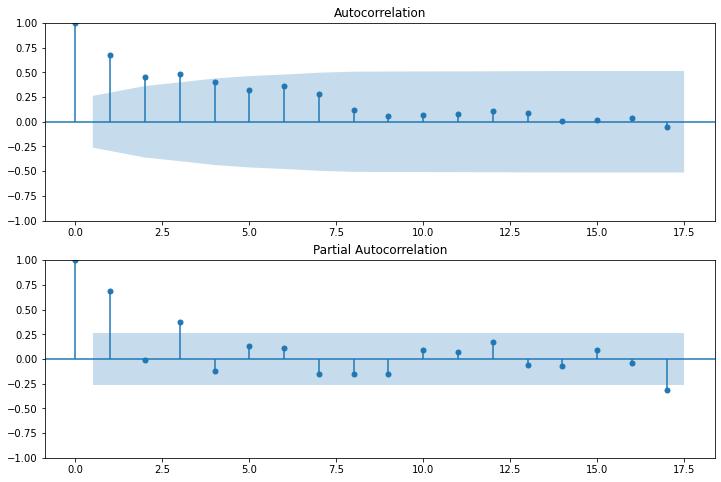

In [35]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(wpi['WPI_percentage_change'].dropna(),lags=17,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(wpi['WPI_percentage_change'].dropna(),lags=17,ax=ax2)

C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


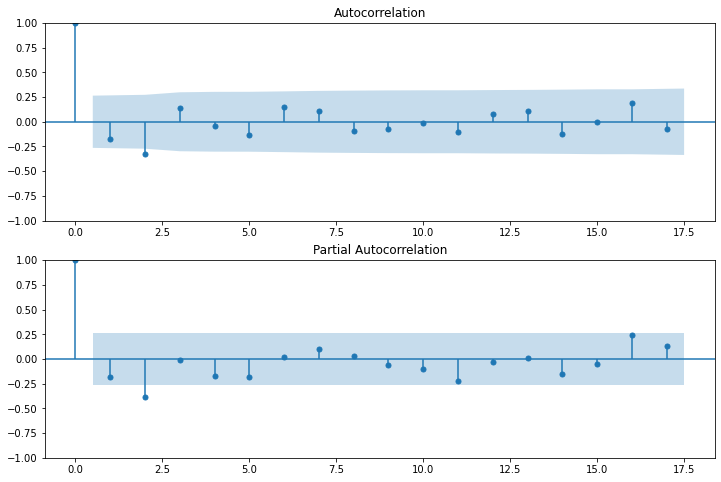

In [36]:
#Create autocorrelation and partial autocorrelation plots for First differenced WPI percentage change time series

%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(wpi['First_diff_WPI_percentage_change'].dropna(),lags=17,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(wpi['First_diff_WPI_percentage_change'].dropna(),lags=17,ax=ax2)

### Arima model for Time series forecasting

In [37]:
# Create a copy of wpi dataframe
detrend_df = wpi.copy()
# drop the original value column and leave the first differenced values only
detrend_df = detrend_df.drop(detrend_df.iloc[:,0:1],axis =1)
# drop null values
detrend_wpi_df = detrend_df.dropna()
detrend_wpi_df.head()

,First_diff_WPI_percentage_change
Qtr,
2009-06-01,-0.1
2009-09-01,-0.4
2009-12-01,0.4
2010-03-01,0.2
2010-06-01,-0.2


In [38]:
wpi_df_arima = wpi.copy()

In [39]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(wpi_df_arima['WPI_percentage_change'],order=(3,3,6))
model_fit=model.fit()
model_fit.summary()

C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     WPI_percentage_change   No. Observations:                   56
Model:                    ARIMA(3, 3, 6)   Log Likelihood                  21.151
Date:                   Tue, 16 May 2023   AIC                            -22.302
Time:                           14:26:13   BIC                             -2.599
Sample:                       03-01-2009   HQIC                           -14.725
                            - 12-01-2022                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7345      0.388     -4.472      0.000      -2.495      -0.974
ar.L2         -1.7289      0.316     -5.464      0.000      -2.349      -1.109
ar.L3         -0.9206      0.376     -2.451      0.014      -1.657      -0.184
ma.L1         -0.4532      1.089     -0.416      0.677      -2.588       1.682
ma.L2         -0.7946      0.990     -0.803      0.422      -2.734       1.145
ma.L3         -0.5913      2.709     -0.218      0.827      -5.901       4.719
ma.L4          0.2577      0.652      0.395      0.693      -1.020       1.536
ma.L5          0.9566      1.915      0.500      0.617      -2.797       4.710
ma.L6         -0.3263      0.636     -0.513      0.608      -1.572       0.920
sigma2         0.0194      0.033      0.598      0.550      -0.044       0.083
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.67   Prob(JB):                         0.71
Heteroskedasticity (H):               0.70   Skew:                            -0.19
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Qtr'>

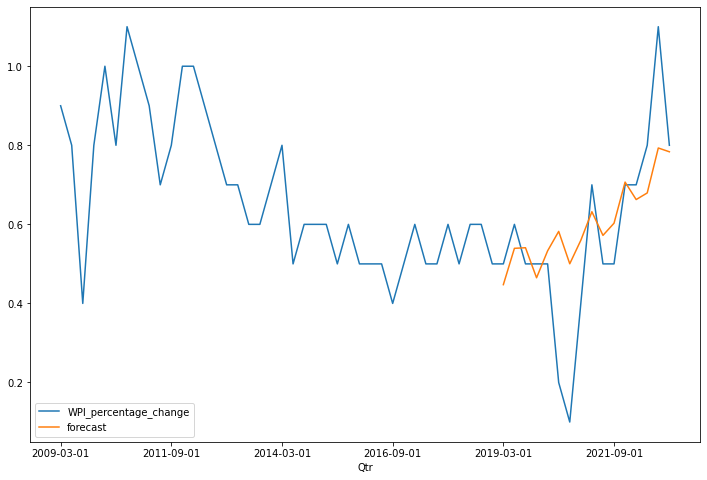

In [40]:
wpi_df_arima['forecast']=model_fit.predict(start=40,end=60,dynamic=True)
wpi_df_arima[['WPI_percentage_change','forecast']].plot(figsize=(12,8))

In the above Arima model, the P-value of Autoregressive (ar) for all three lags are less than 0.05 so that we can say there is enough eveidence to reject the null hypothesis that autoregressive coefficients for lag 1 ,lag 2 and lag 3 are not statistically significant. In other words, we can accept that the the autoregressive coefficients for lag 1, lag 2 and lag 3 are statistically significant.

However, the P-value of other coefficients are greater than 0.05 therefore we cannot say they are statistically significant in this model. Further, by looking at the forecaste line in the graph, eventhogh the trend of forecaste line is somewhat reflectig the original values, the most of predictions are not strong enough. Therefore we can say this model needs to be improved. 